In [2]:
# =============================================================================
# MATHEMATICAL AND PLOTTING TOOLS
# =============================================================================
import sys
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Standard plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits import mplot3d  # For 3D plots

# Interactive plotting
import plotly.express as px

# =============================================================================
# ASTRONOMY COORDINATES AND UNITS
# =============================================================================
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord

# =============================================================================
# GALA - GALACTIC DYNAMICS LIBRARY
# =============================================================================
import gala.potential as gala_potential        # Gravitational potentials
import gala.dynamics as gala_dynamics         # Orbit integration and dynamics
import gala.integrate as gi        # Integration utilities
from gala.dynamics import mockstream as ms  # Mock stream generation
from gala.units import galactic    # Galactic unit system
import gala

# =============================================================================
# DATA QUERY TOOLS
# =============================================================================
# Check if we're in Colab and install astroquery if needed
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install astroquery

try:
    from astroquery.gaia import Gaia
    from astroquery.vizier import Vizier
    ASTROQUERY_AVAILABLE = True
except ImportError:
    print("astroquery not available - data queries disabled")
    ASTROQUERY_AVAILABLE = False
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# =============================================================================
# SETUP DEFAULT PARAMETERS
# =============================================================================
# Set default Astropy Galactocentric frame parameters (v4.0 standards)
_ = coord.galactocentric_frame_defaults.set('v4.0')
gala_modified=True
print("All imports successful!")
print(f"Running in Colab: {IN_COLAB}")
print(f"Astroquery available: {ASTROQUERY_AVAILABLE}")


astroquery not available - data queries disabled
All imports successful!
Running in Colab: False
Astroquery available: False


In [3]:
# This creates the galactic potential it combines three main galactic components: bar, disk, and a dark matter halo
galactic_potential = gala_potential.CCompositePotential()

# BAR COMPONENT Uses Long-Murali bar potential for realistic bar-like mass distribution
galactic_potential['bar'] = gala_potential.LongMuraliBarPotential(
        m=2E10*u.Msun,        # Total mass of the bar
        a=4*u.kpc,            # Semi-major axis length(bar length scale)
        b=0.5*u.kpc,          # Semi-minor axis in xy-plane (bar width)
        c=0.5*u.kpc,          # Semi-minor axis in z-direction (bar thickness)
        alpha=25*u.degree,    # Bar orientation angle from x-axis
        units=galactic)       # Use galactic unit system (kpc, Myr, Msun)

# DISK COMPONENT Uses Miyamoto-Nagai potential for realistic disk mass distribution
galactic_potential['disk'] = gala_potential.MiyamotoNagaiPotential(
        m=5E10*u.Msun,        # Total disk mass
        a=3.*u.kpc,           # Radial scale length (disk size)
        b=280.*u.pc,          # Vertical scale height(disk thickness)
        units=galactic)       # Use galactic unit system

# HALO COMPONENT - Models the dark matter halo surrounding the galaxy
# Uses NFW (Navarro-Frenk-White) profile,  for dark matter halos
galactic_potential['halo'] = gala_potential.NFWPotential(
        m=6E11*u.Msun,        # Virial mass
        r_s=20.*u.kpc,        # Scale radius(concentration parameter)
        units=galactic)       # Use galactic unit system

In [4]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

# Your existing galactic_potential setup...

# Create grid
x = np.linspace(-10, 10, 100) * u.kpc  # ±10 kpc, 100 points
y = np.linspace(-10, 10, 100) * u.kpc
z = np.linspace(-10, 10, 100) * u.kpc

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()]) * u.kpc

# Evaluate potential on grid
potential_values = galactic_potential.energy(coords).to(u.km**2/u.s**2)

# Reshape to grid
pot_grid = potential_values.reshape(X.shape)

# Create WCS (World Coordinate System) header
w = WCS(naxis=3)
w.wcs.crpix = [50.5, 50.5, 50.5]  # Reference pixel (center of 100-point grid)
w.wcs.cdelt = [0.2, 0.2, 0.2]     # Grid spacing in kpc (20 kpc / 100 points)
w.wcs.crval = [0.0, 0.0, 0.0]     # Reference coordinate (center at origin)
w.wcs.ctype = ["LINEAR", "LINEAR", "LINEAR"]
w.wcs.cunit = ["kpc", "kpc", "kpc"]

# Create primary HDU with WCS header
hdu = fits.PrimaryHDU(pot_grid.value, header=w.to_header())

# Add some additional useful headers
hdu.header['BUNIT'] = 'km2/s2'     # Units of the data
hdu.header['COMMENT'] = 'Galactic potential on 3D grid'
hdu.header['COMMENT'] = 'Grid covers -10 to +10 kpc in x,y,z'

# Write to file
hdu.writeto('galaxy_potential.fits', overwrite=True)

print("FITS file created with coordinate headers")
print(f"Grid shape: {pot_grid.shape}")
print(f"Value range: {pot_grid.value.min():.1f} to {pot_grid.value.max():.1f}")

FITS file created with coordinate headers
Grid shape: (100, 100, 100)
Value range: -193616.9 to -104133.7


Text(0, 0.5, '$y$ [kpc]')

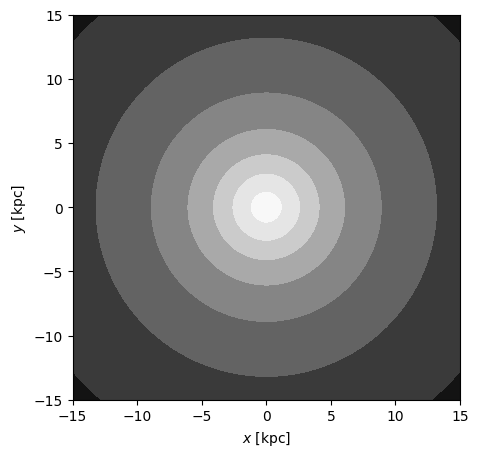

In [5]:
#a simple plot of the galactic_potential
grid = np.linspace(-15,15,128)
test_orbit_fig, test_orbit_axes = plt.subplots(1, 1, figsize=(5, 5))
test_orbit_fig = galactic_potential.plot_contours(grid=(grid, grid, 0.), ax=test_orbit_axes, cmap='Greys')
test_orbit_axes.set_xlabel("$x$ [kpc]")
test_orbit_axes.set_ylabel("$y$ [kpc]")

## **Star Cluster Information**
*Ra, dec, pmra, pmdec: [Vasiliev et al., 2021](http://simbad.u-strasbg.fr/simbad/sim-ref?querymethod=bib&simbo=on&submit=submit+bibcode&bibcode=2021MNRAS.505.5978V) from here*

*Mass, distance, radial vel: [this website](https://people.smp.uq.edu.au/HolgerBaumgardt/globular/).*

Change these values if we obtain better data!
Note: To accept the current position of the cluster and generate a stream **backwards in time**, make the time step ***NEGATIVE***.

In [6]:
# Set up the globular cluster as a coordinate point and converts it to Galactocentric coordinates

# NEW CODE - Replace with this:
from gc_stream_toolkit import get_cluster

cluster = get_cluster("pal5")
globular_cluster=cluster.skycoord

gc_gala_phase_space=cluster.phase_space_position
cluster_mass=cluster.mass

# Transform from ICRS coordinates to Galactocentric coordinates
gc_galactocentric_coords = globular_cluster.transform_to(coord.Galactocentric)

# Display the Galactocentric coordinates
print(f"X: {gc_galactocentric_coords.x}")
print(f"Y: {gc_galactocentric_coords.y}")
print(f"Z: {gc_galactocentric_coords.z}")

X: 7.1970585973536085 kpc
Y: 0.22364519881190806 kpc
Z: 15.725603167408744 kpc


        Use name instead. [gala.dynamics.core]


In [7]:
# Sets up the rotating frame (for the bar)
Om_bar = 42. * u.km/u.s/u.kpc
frame = gala_potential.ConstantRotatingFrame(Omega=[0, 0, Om_bar.value] * Om_bar.unit,
                                             units=galactic)

# Step 4: Create the Hamiltonian (potential + frame) which is a potential method that takes into account the movement of the bar
hamiltonian_potential = gala_potential.Hamiltonian(potential=galactic_potential, frame=frame)

# Step 5: Convert to Gala's PhaseSpacePosition format
gc_gala_phase_space = gala_dynamics.PhaseSpacePosition(gc_galactocentric_coords.data)

print("Galactocentric coordinates:")
print(f"Position: {gc_galactocentric_coords.cartesian.xyz}")
print(f"Velocity: {gc_galactocentric_coords.velocity.d_xyz}")

Galactocentric coordinates:
Position: [ 7.1970586   0.2236452  15.72560317] kpc
Velocity: [ -45.687804   -149.93820799  -11.30431029] km / s


        Use name instead. [gala.dynamics.core]


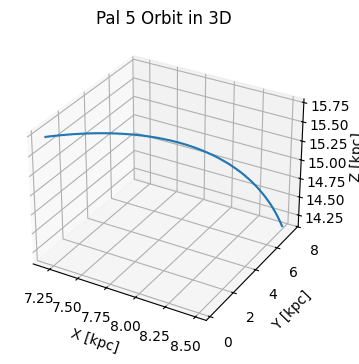

In [8]:
# Create a test orbit
# we set out time step to be -.5 million years to travel back in time
test_orbit = hamiltonian_potential.integrate_orbit(gc_gala_phase_space, dt=-.5 * u.Myr, n_steps=100)

# Transform to inertial frame
test_orbit_inertial = test_orbit.to_frame(gala_potential.StaticFrame(galactic))

# set up the figure
test_orbit_fig = plt.figure(figsize=(4, 4))
test_orbit_axes = test_orbit_fig.add_subplot(111, projection='3d')
test_orbit_axes.plot(test_orbit_inertial.x.value, test_orbit_inertial.y.value, test_orbit_inertial.z.value, 'o-', markersize=.1)
#set labels
test_orbit_axes.set_xlabel('X [kpc]'),
test_orbit_axes.set_ylabel('Y [kpc]'),
test_orbit_axes.set_zlabel('Z [kpc]'),
test_orbit_axes.set_title('Pal 5 Orbit in 3D')

plt.show()


        Use name instead. [gala.dynamics.orbit]
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspe

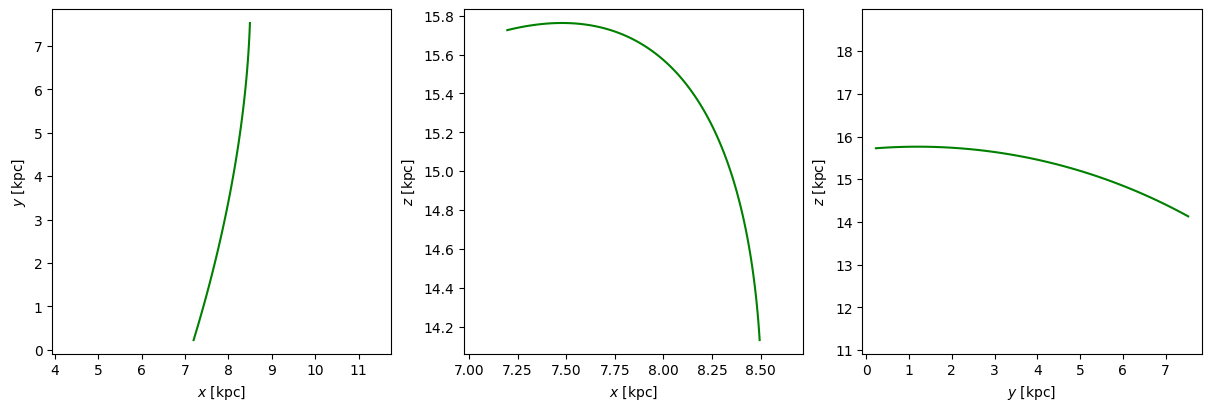

In [9]:
#Orbits
#initgrating with the hamiltonian_frame
orbit_rotating = hamiltonian_potential.integrate_orbit(gc_gala_phase_space, dt=-0.5 * u.Myr, n_steps=100)

orbit_inertial = orbit_rotating.to_frame(gala_potential.StaticFrame(galactic))

test_orbit_fig = orbit_inertial.plot(color='green')


Static frame:   (8.49469062, 7.53101778, 14.13211885) kpc
Rotating frame: (8.49468669, 7.53098597, 14.13212983) kpc


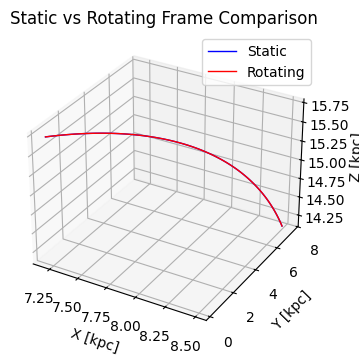

In [10]:
# Compare static vs rotating frame orbits
orbit_static = galactic_potential.integrate_orbit(gc_gala_phase_space, dt=-0.5 * u.Myr, n_steps=100)

orbit_rotating = hamiltonian_potential.integrate_orbit(gc_gala_phase_space, dt=-0.5 * u.Myr, n_steps=100)
orbit_rotating_static = orbit_rotating.to_frame(gala_potential.StaticFrame(galactic))

print(f"Static frame:   {orbit_static[-1].pos}")
print(f"Rotating frame: {orbit_rotating_static[-1].pos}")

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(orbit_static.x.value, orbit_static.y.value, orbit_static.z.value, '-', linewidth=1, color='blue', label='Static')
ax.plot(orbit_rotating_static.x.value, orbit_rotating_static.y.value, orbit_rotating_static.z.value, '-', linewidth=1, color='red', label='Rotating')
ax.legend()
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_title('Static vs Rotating Frame Comparison')
plt.show()

In [11]:
stream_distribution_function = ms.ChenStreamDF()
cluster_internal_potential = gala_potential.PlummerPotential(m=cluster_mass, b=4 * u.pc, units=galactic)

# Generate the mock stream
stream_generator = ms.MockStreamGenerator(stream_distribution_function,
                                          hamiltonian_potential,
                                          progenitor_potential=cluster_internal_potential)



# Step 1: Find where cluster was in the past
past_orbit = hamiltonian_potential.integrate_orbit(gc_gala_phase_space,
                                                  dt=-0.5*u.Myr,
                                                  n_steps=2800)

# Step 2: Start stream generation from the PAST position, integrate FORWARD
past_position = past_orbit[-1]  # Furthest back in time
print(past_position)

stream_orbit, _ = stream_generator.run(gc_gala_phase_space, cluster_mass,
                                       dt=+0.5*u.Myr,  # POSITIVE = forward in time
                                       n_steps=1000,
                                       output_every=10,  # Save every 10th timestep
                                       output_filename="Code outputs/pal5_stream_evolution.h5",
                                       overwrite=True)  # HDF5 output

print("Stream generation complete!")
print("Temporal data saved to: ngc6569_stream_evolution.h5")
print(f"Total timesteps: {2800}")
print(f"Saved snapshots: {2800//10} (every 10th step)")
# Convert to observational coordinate frames
stream_icrs = stream_orbit.to_coord_frame(coord.ICRS())

stream_galactic = stream_orbit.to_coord_frame(coord.Galactic())



pos=(0.3177708, 15.31774273, 2.4282299) kpc
vel=(0.07088704, -0.02311, -0.17557817) kpc / Myr
Stream generation complete!
Temporal data saved to: ngc6569_stream_evolution.h5
Total timesteps: 2800
Saved snapshots: 280 (every 10th step)


In [12]:
coord_df = pd.DataFrame({
    "RA": stream_icrs.ra.degree,
    "Dec": stream_icrs.dec.degree,
    "X": stream_orbit.x,
    "Y": stream_orbit.y,
    "Z": stream_orbit.z,
    "RV": stream_icrs.radial_velocity,
    "pm_ra": stream_icrs.pm_ra_cosdec,
    "pm_dec": stream_icrs.pm_dec,
    "l": stream_galactic.l,
    "b": stream_galactic.b,
    "Release Time": stream_orbit.release_time.value
})

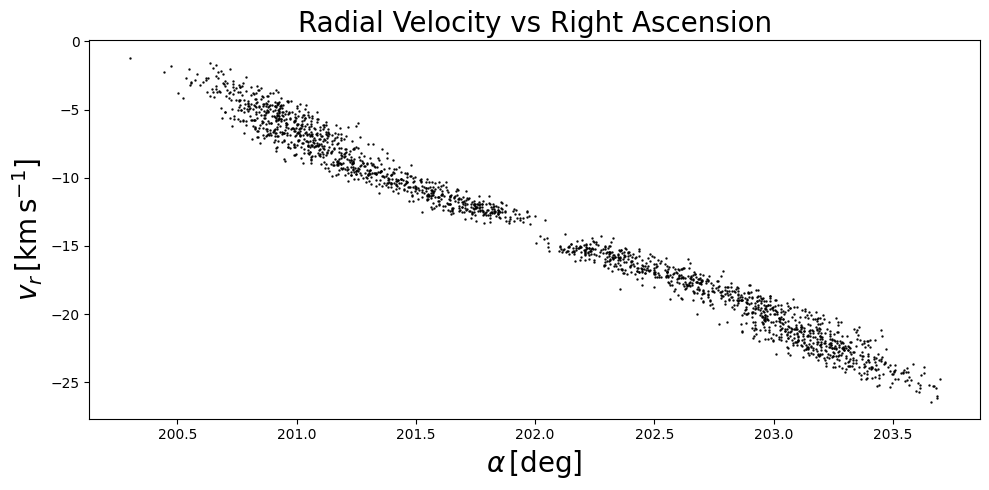

In [13]:
radial_velocity_plot_fig, radial_velocity_plot_axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot stream particles
radial_velocity_plot_axes.scatter(stream_icrs.ra.degree,
                                 stream_icrs.radial_velocity.to(u.km/u.s),
                                 marker='.', s=2, alpha=0.95, color='k')

# Labels and title
plt.title("Radial Velocity vs Right Ascension", fontsize=20)
radial_velocity_plot_axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize=20)
radial_velocity_plot_axes.set_ylabel(r'$v_r\,[{\rm km}\,{\rm s}^{-1}]$', fontsize=20)

plt.tight_layout()
plt.show()

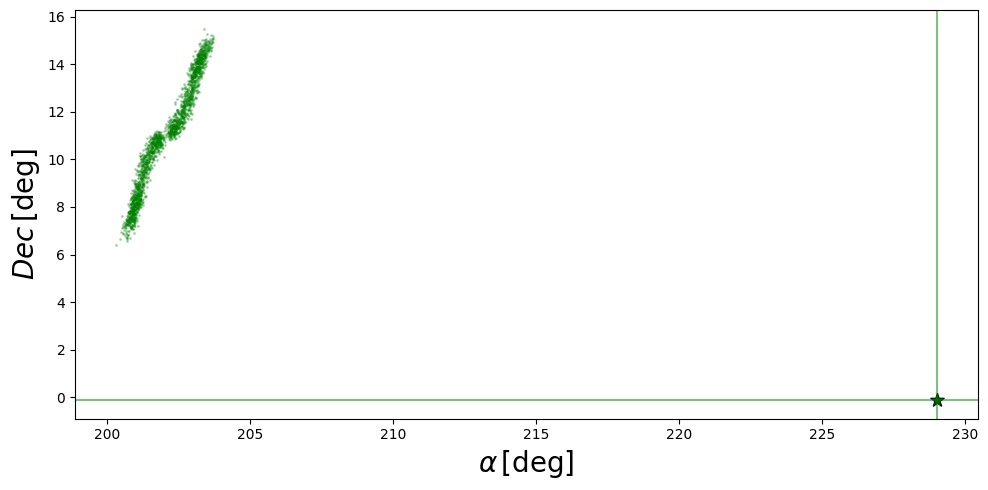

In [14]:
ra_dec_plot_fig, ra_dec_plot_axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Plot the stream
ra_dec_plot_axes.scatter(stream_icrs.ra.degree, stream_icrs.dec.degree,
                        marker='.', s=5, alpha=0.25, color='g')

# Pal 5 cluster coordinates
cluster_ra = 229.019
cluster_dec = -0.121

# Plot cluster position with multiple marker sizes
ra_dec_plot_axes.scatter([cluster_ra], [cluster_dec],
                        marker='*', s=100, alpha=0.95, color='k')
ra_dec_plot_axes.scatter([cluster_ra], [cluster_dec],
                        marker='*', s=50, alpha=0.5, color='g')

# Reference lines at cluster position
ra_dec_plot_axes.axvline(x=cluster_ra, alpha=0.5, color='g')
ra_dec_plot_axes.axhline(y=cluster_dec, alpha=0.5, color='g')

# Labels
ra_dec_plot_axes.set_xlabel(r'$\alpha\,[{\rm deg}]$', fontsize=20)
ra_dec_plot_axes.set_ylabel(r'$Dec\,[{\rm deg}]$', fontsize=20)

ra_dec_plot_fig.tight_layout()
plt.show()

In [15]:
# Create interactive 3D plot with plotly
tidal_tails_interactive_fig = px.scatter_3d(
    x=stream_orbit.x.value,
    y=stream_orbit.y.value,
    z=stream_orbit.z.value,
    title='Pal 5 Tidal Tails',
    labels={'x': 'X [kpc]', 'y': 'Y [kpc]', 'z': 'Z [kpc]'},
    opacity=.6,
)

tidal_tails_interactive_fig.update_traces(
    marker=dict(size=1)  # Adjust this number (1-10 typical range)
)

# Update layout for better visualization
tidal_tails_interactive_fig.update_layout(
    width=800,
    height=800,
    scene=dict(
        aspectmode='cube'
    )
)

tidal_tails_interactive_fig.show()